In [1]:
import os
import gc
import cv2
import time
import itertools
import sklearn

import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns

from keras import backend as K
from matplotlib import pyplot as plt

from glob import glob
from tqdm import tqdm
from itertools import cycle
from tabulate import tabulate
from pandas import DataFrame
from keras import regularizers, optimizers, initializers

from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from keras.models import Sequential, Model
from keras.layers.core import Dense
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from keras_preprocessing.image import ImageDataGenerator

from keras.layers import (
    Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation
)
from sklearn.metrics import (
    roc_curve, auc, multilabel_confusion_matrix, ConfusionMatrixDisplay, classification_report, confusion_matrix
)
from tensorflow.keras.applications import (
    VGG16, VGG19, InceptionV3, Xception, DenseNet121, ResNet50V2, MobileNet, MobileNetV2, EfficientNetB0, EfficientNetB1, 
    EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
)

In [2]:
def plot_class_samples(samples_count):
    labels = list(samples_count.keys())
    count = list(samples_count.values())
    
    plt.rcParams['figure.dpi'] = 150
    fig, ax = plt.subplots(figsize =(18, 8))
    ax.barh(labels, count)
    
    # Remove axes splines
    for s in ['top', 'bottom', 'left', 'right']:
        ax.spines[s].set_visible(False)
    
    # Remove x, y Ticks
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    
    # Add padding between axes and labels
    ax.xaxis.set_tick_params(pad = 2)
    ax.yaxis.set_tick_params(pad = 3)
    
    # Add x, y gridlines
    ax.grid(visible = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.2)
    
    # Show top values
    ax.invert_yaxis()
    
    # Add annotation to bars
    for i in ax.patches:
        plt.text(
            i.get_width() + 0.2, 
            i.get_y() + 0.5, 
            str(round((i.get_width()), 2)), 
            fontsize = 10, 
            fontweight = 'bold', 
            color ='grey'
        )
    
    ax.set_title('Samples Belonging to Each Class Label', loc ='center')
    plt.show()
    

In [3]:
# Data reading on Local Machine
# image_paths = {os.path.basename(x): x for x in glob(os.path.join('.', 'images', '*.png'))}
# df = pd.read_csv("./dataset_information/Data_Entry_2017.csv")

# Data reading on Kaggle
image_paths = {os.path.basename(x): x for x in glob(os.path.join('..', 'input', 'data', 'images*', 'images', '*.png'))}
df = pd.read_csv("/kaggle/input/data/Data_Entry_2017.csv")

df = df.drop(
    columns = [
        "Follow-up #", 
        "Patient ID", 
        "Patient Age", 
        "Patient Gender", 
        "OriginalImage[Width",
        "Height]",
        "OriginalImagePixelSpacing[x",
        "y]",
        "Unnamed: 11",
        "View Position"
    ], 
    axis = 1
)

df["Image Paths"] = " "
for row_index in tqdm(range(len(df)), ncols = 100):
    img_name = df.iloc[row_index][0]
    path = image_paths[img_name]
    df["Image Paths"][row_index] = path

unique_labels = set(itertools.chain.from_iterable(df["Finding Labels"].apply(lambda x : x.split('|')).values)) 
one_hot_labels = pd.DataFrame(0.0, index = np.arange(len(df)), columns = unique_labels)

for index, row in tqdm(df.iterrows()):
    labels = row["Finding Labels"].split('|')
    for label in labels:
        one_hot_labels.iloc[index][label] = 1.0

df = pd.concat([df, one_hot_labels], axis = 1)
df = df.drop(columns = ["Finding Labels"], axis = 1)
# df.head(3)

# new_dataset_dir = "/kaggle/input/gan-samples/GAN Images"

# df2 = pd.DataFrame(
#     columns=[
#         'Image Index', 'Image Paths', 
#         'Pneumonia', 
#         'Edema', 
#         'Emphysema',
#         'Hernia', 
#         'Mass', 
#         'Effusion', 
#         'Nodule', 
#         'Consolidation', 
#         'No Finding',
#         'Pneumothorax', 
#         'Cardiomegaly', 
#         'Pleural_Thickening', 
#         'Fibrosis',
#         'Atelectasis', 
#         'Infiltration'
#     ])

# # Iterate through the folders in the new dataset directory
# for class_name in os.listdir(new_dataset_dir):
#     class_dir = os.path.join(new_dataset_dir, class_name)
#     if not os.path.isdir(class_dir):
#         continue

#     # Iterate through the images in each class folder and extract the necessary information
#     for image_name in tqdm(os.listdir(class_dir)):
#         image_path = os.path.join(class_dir, image_name)
#         image_index = image_name  # Assuming image name is unique and can be used as the index

#         # Create a dictionary to hold the new row data
#         new_row = {
#             'Image Index': image_index,
#             'Image Paths': image_path,
#             'Pneumonia': 1 if class_name == 'Pneumonia' else 0,
#             'Edema': 1 if class_name == 'Edema' else 0,
#             'Emphysema': 1 if class_name == 'Emphysema' else 0,
#             'Hernia': 1 if class_name == 'Hernia' else 0,
#             'Mass': 1 if class_name == 'Mass' else 0,
#             'Effusion': 1 if class_name == 'Effusion' else 0,
#             'Nodule': 1 if class_name == 'Nodule' else 0,
#             'Consolidation': 1 if class_name == 'Consolidation' else 0,
#             'No Finding': 1 if class_name == 'No Finding' else 0,
#             'Pneumothorax': 1 if class_name == 'Pneumothorax' else 0,
#             'Cardiomegaly': 1 if class_name == 'Cardiomegaly' else 0,
#             'Pleural_Thickening': 1 if class_name == 'Pleural_Thickening' else 0,
#             'Fibrosis': 1 if class_name == 'Fibrosis' else 0,
#             'Atelectasis': 1 if class_name == 'Atelectasis' else 0,
#             'Infiltration': 1 if class_name == 'Infiltration' else 0
#         }
        
#         df2 = df2.append(new_row, ignore_index=True)
        
# df = pd.concat([df, df2], ignore_index=True)
# columns_to_convert = [
#     'Pneumonia', 'Edema', 'Emphysema', 'Hernia', 'Mass', 'Effusion', 'Nodule', 'Consolidation', 'No Finding',
#     'Pneumothorax', 'Cardiomegaly', 'Pleural_Thickening', 'Fibrosis', 'Atelectasis', 'Infiltration'
# ]
# df[columns_to_convert] = df[columns_to_convert].astype(float)
# df2[columns_to_convert] = df2[columns_to_convert].astype(float)

# df_train, df_test = train_test_split(dataset_info.sample(n = 60000), test_size = 0.20, random_state = 142)
df_train, df_test = train_test_split(df, test_size = 0.20, random_state = 500)
df_train, df_val = train_test_split(df_train, test_size = 0.10, random_state = 0)

# df_train = pd.concat([df_train, df2], ignore_index=True)

print(f"Training Samples: {len(df_train)}\nValidation Samples: {len(df_val)}\nTesting Samples: {len(df_test)}")

100%|█████████████████████████████████████████████████████| 112120/112120 [01:37<00:00, 1148.02it/s]
112120it [00:17, 6513.53it/s]


Training Samples: 80726
Validation Samples: 8970
Testing Samples: 22424


In [4]:
df

,Image Index,Image Paths,Fibrosis,Hernia,Pneumothorax,Pneumonia,Atelectasis,Emphysema,Consolidation,Nodule,Mass,Pleural_Thickening,Effusion,Edema,Infiltration,No Finding,Cardiomegaly
0,00000001_000.png,../input/data/images_001/images/00000001_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,00000001_001.png,../input/data/images_001/images/00000001_001.png,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,00000001_002.png,../input/data/images_001/images/00000001_002.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,00000002_000.png,../input/data/images_001/images/00000002_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,00000003_000.png,../input/data/images_001/images/00000003_000.png,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,../input/data/images_012/images/00030801_001.png,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
112116,00030802_000.png,../input/data/images_012/images/00030802_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
112117,00030803_000.png,../input/data/images_012/images/00030803_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
112118,00030804_000.png,../input/data/images_012/images/00030804_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [5]:
CLASS_LABELS = [
    "Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Effusion", "Emphysema", "Fibrosis", "Hernia", 
    "Infiltration", "Mass", "No Finding", "Nodule", "Pleural_Thickening", "Pneumonia","Pneumothorax"
]

USE_TRANSFER_LEARNING = True
IMAGE_SIZE = (400, 400,)
BATCH_SIZE = 16
EPOCHS = 5
LEARNING_RATE = 0.0001 if USE_TRANSFER_LEARNING else 0.01

BETA_FOR_BIASED_RECALL = 1.3
BETA_FOR_BIASED_PRECISION = 0.7
BETA_WITH_NO_BIAS = 1

THRESHOLDS = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

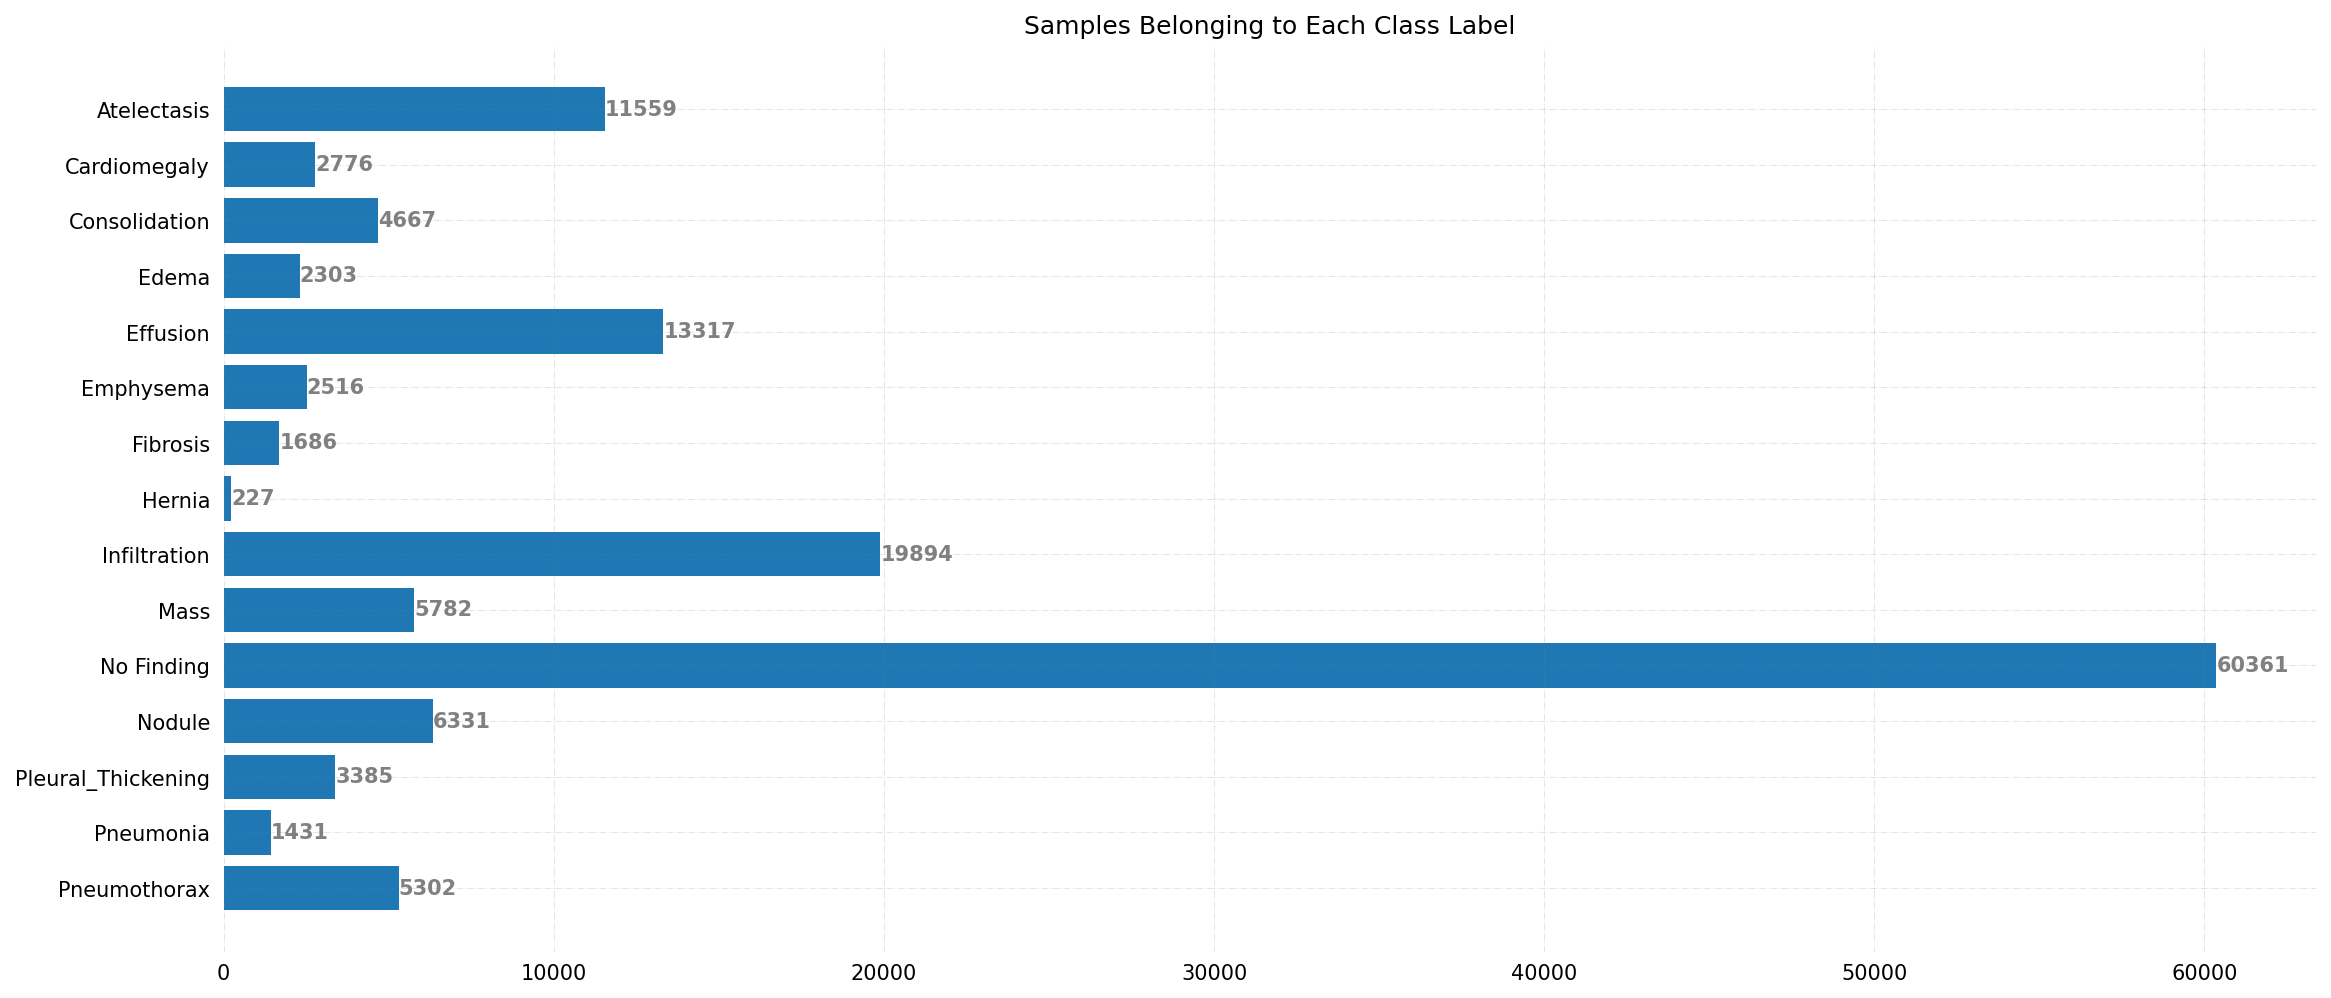

In [6]:
SAMPLES_PER_CLASS = dict()

for label in CLASS_LABELS:
    SAMPLES_PER_CLASS[label] = 0

for label in CLASS_LABELS:
    SAMPLES_PER_CLASS[label] = int(df[label].sum())
    
plot_class_samples(SAMPLES_PER_CLASS)

<AxesSubplot:>

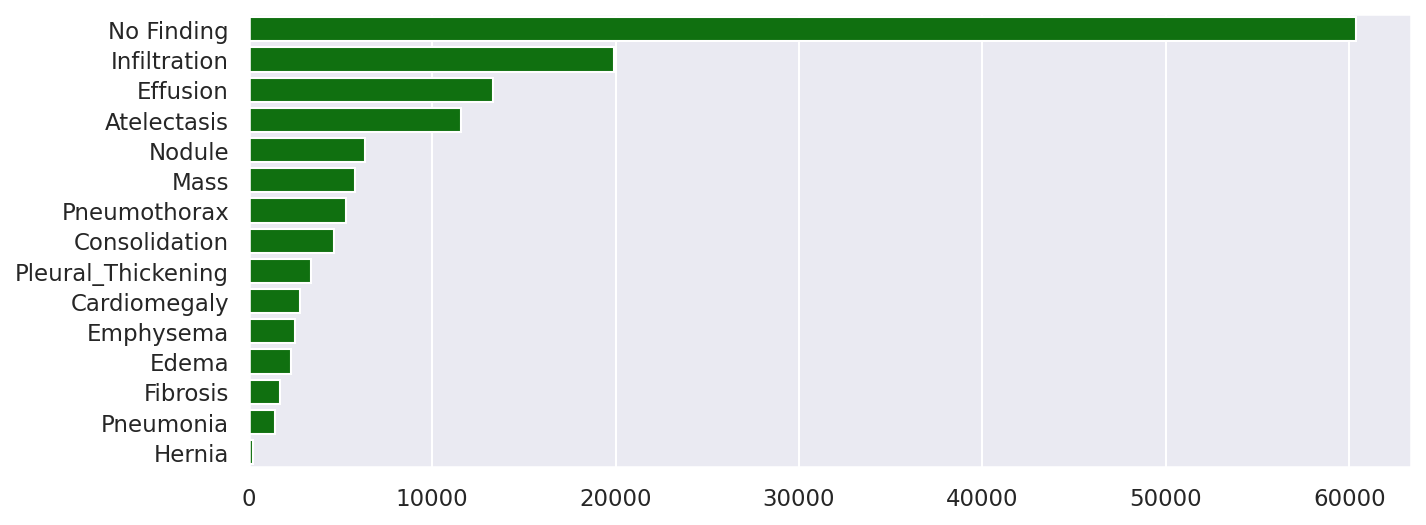

In [7]:
SORTED_SAMPLES_PER_CLASS = dict(sorted(SAMPLES_PER_CLASS.items(), key=lambda x:x[1], reverse = True))
keys = list(SORTED_SAMPLES_PER_CLASS.keys())
values = list(SORTED_SAMPLES_PER_CLASS.values())

sns.set(rc = {'figure.figsize' : (10, 4)})
sns.barplot(x = values, y = keys, color = "green")

<AxesSubplot:>

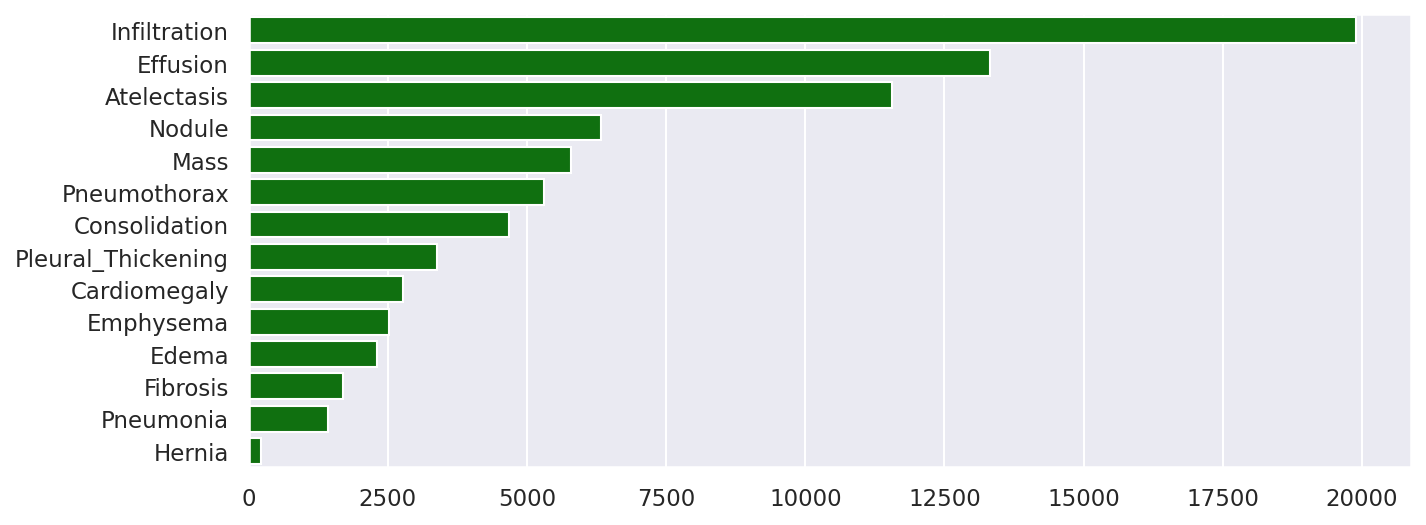

In [8]:
del(SORTED_SAMPLES_PER_CLASS["No Finding"])
keys = list(SORTED_SAMPLES_PER_CLASS.keys())
values = list(SORTED_SAMPLES_PER_CLASS.values())

sns.barplot(x = values, y = keys, color = "green")

In [9]:
CLASS_WEIGHTS = dict()
label_with_most_samples = max(SAMPLES_PER_CLASS, key = SAMPLES_PER_CLASS.get)

for index, label in enumerate(CLASS_LABELS):
    CLASS_WEIGHTS[index] = SAMPLES_PER_CLASS[label_with_most_samples] / (len(CLASS_LABELS) * SAMPLES_PER_CLASS[label])

tabulated_weights_data = []    
for i in range(15):
    row = [CLASS_LABELS[i], SAMPLES_PER_CLASS[CLASS_LABELS[i]], CLASS_WEIGHTS[i]]
    tabulated_weights_data.append(row)
    
print(tabulate(tabulated_weights_data, headers = ["Class Name", "Samples", "Weightage"], tablefmt = "github", numalign = "left"))

| Class Name         | Samples   | Weightage   |
|--------------------|-----------|-------------|
| Atelectasis        | 11559     | 0.348133    |
| Cardiomegaly       | 2776      | 1.44959     |
| Consolidation      | 4667      | 0.862238    |
| Edema              | 2303      | 1.74732     |
| Effusion           | 13317     | 0.302175    |
| Emphysema          | 2516      | 1.59939     |
| Fibrosis           | 1686      | 2.38675     |
| Hernia             | 227       | 17.7272     |
| Infiltration       | 19894     | 0.202275    |
| Mass               | 5782      | 0.695964    |
| No Finding         | 60361     | 0.0666667   |
| Nodule             | 6331      | 0.635613    |
| Pleural_Thickening | 3385      | 1.18879     |
| Pneumonia          | 1431      | 2.81207     |
| Pneumothorax       | 5302      | 0.758971    |


In [10]:
def apply_sharpening(image):
    sharp_kernel = np.array(
        [
            [0, -1, 0], 
            [-1, 5, -1], 
            [0, -1, 0]
        ])
    output = cv2.filter2D(src = image, ddepth = -1, kernel = sharp_kernel)
    return output


def apply_min_max_scaling(image):
    from skimage.transform import rescale
    image = (image - image.min()) / (image.max() - image.min())
#     image = rescale(image, 0.25, multichannel = True, mode = "constant")
    return image

train_data_generator = ImageDataGenerator(
    rescale = 1. / 255,
    shear_range = 0.2,
    zoom_range = 0.05,
    width_shift_range = 0.05,
    height_shift_range = 0.05,
    fill_mode = "constant",
    preprocessing_function = apply_sharpening
)
val_data_generator = ImageDataGenerator(
    rescale = 1. / 255, 
    preprocessing_function = apply_sharpening
)
test_data_generator = ImageDataGenerator(
    rescale = 1. / 255, 
    preprocessing_function = apply_sharpening
)


def flow_from_dataframe(image_generator, dataframe):
    df_gen = image_generator.flow_from_dataframe(
        dataframe,
        x_col = "Image Paths", 
        y_col = dataframe.columns[2:],
        target_size = IMAGE_SIZE,
        color_mode = 'rgb',
        class_mode = 'raw',
        shuffle = False,
        batch_size = BATCH_SIZE
    )
    return df_gen


train_gen = flow_from_dataframe(image_generator = train_data_generator, dataframe = df_train)
valid_gen = flow_from_dataframe(image_generator = val_data_generator, dataframe = df_val)
test_gen = flow_from_dataframe(image_generator = test_data_generator, dataframe = df_test)


Found 80726 validated image filenames.
Found 8970 validated image filenames.
Found 22424 validated image filenames.


In [11]:
class MultiLabelCrossEntropy:
    def __init__(self, labels: DataFrame, epsilon = 1e-7):
        self.epsilon = epsilon
        self.N = labels.shape[0]
        
        self.freq_pos = np.sum(labels == 1, axis=0)
        self.freq_neg = np.sum(labels == 0, axis=0)
        self.pos_weights = self.freq_neg  / self.N
        self.neg_weights = self.freq_pos  / self.N
        
        self.print_class_weights()
        
    def calculate_loss(self, true_y, pred_y):
        loss = 0.0
        for i in range(len(self.pos_weights)):
            loss += (-1 * K.mean(self.pos_weights[i] * true_y[:,i] * K.log(pred_y[:,i] + self.epsilon))) + (-1 * K.mean(self.neg_weights[i] * (1 - true_y[:,i]) * K.log(1 - pred_y[:,i] + self.epsilon)))
        
        return loss
        
    def contribution(self):
        return self.freq_pos * self.pos_weights, self.freq_neg * self.neg_weights
    
    def print_class_weights(self):
        tabulated_weights_data = []
        for i, l in zip(range(15), CLASS_LABELS):
            label_samples_percentage = (self.freq_pos[i] / SAMPLES_PER_CLASS[l]) * 100 
            row = [CLASS_LABELS[i], SAMPLES_PER_CLASS[l], self.freq_pos[i], label_samples_percentage, self.freq_neg[i], self.pos_weights[i], self.neg_weights[i]]
            tabulated_weights_data.append(row)
            
        print(tabulate(
            tabulated_weights_data, 
            headers = ["Class", "Total Samples", "Positive Samples [Train]",  "Sample Percentage [Train]","Negative Frequency [Train]", "Positive Weight", "Negative Weight"], 
            tablefmt = "github", 
            numalign = "left"
        ))

        
MLCE_Loss_With_Class_Weights = MultiLabelCrossEntropy(df_train[CLASS_LABELS])

| Class              | Total Samples   | Positive Samples [Train]   | Sample Percentage [Train]   | Negative Frequency [Train]   | Positive Weight   | Negative Weight   |
|--------------------|-----------------|----------------------------|-----------------------------|------------------------------|-------------------|-------------------|
| Atelectasis        | 11559           | 8384                       | 72.5322                     | 72342                        | 0.896143          | 0.103857          |
| Cardiomegaly       | 2776            | 1964                       | 70.7493                     | 78762                        | 0.975671          | 0.0243292         |
| Consolidation      | 4667            | 3350                       | 71.7806                     | 77376                        | 0.958502          | 0.0414984         |
| Edema              | 2303            | 1654                       | 71.8194                     | 79072                        | 0.979511      

In [12]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 4, verbose = 1, mode = 'auto', baseline = None, restore_best_weights = True)

METRICS = [
  tf.keras.metrics.TruePositives(name = 'tp'),
  tf.keras.metrics.FalsePositives(name = 'fp'),
  tf.keras.metrics.TrueNegatives(name = 'tn'),
  tf.keras.metrics.FalseNegatives(name = 'fn'), 
  tf.keras.metrics.BinaryAccuracy(name = 'binary_accuracy', threshold = 0.5),
  tf.keras.metrics.Precision(name = 'precision', thresholds = 0.3),
  tf.keras.metrics.Recall(name = 'recall', thresholds = 0.3),
  tf.keras.metrics.AUC(name = 'auc', multi_label = True, num_labels = 15, thresholds = THRESHOLDS),
  tf.keras.metrics.AUC(name = 'prc', curve = 'PR')
]

DEFINED_OPTIMIZERS = {
    "SGD" : tf.keras.optimizers.SGD(learning_rate = LEARNING_RATE, decay = 1e-6, momentum = 0.9, nesterov = True),
    "ADAM" : tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE, beta_1 = 0.9, beta_2 = 0.999,),
    "RMSPROP" : tf.keras.optimizers.RMSprop(learning_rate = LEARNING_RATE),
    "NADAM" : tf.keras.optimizers.Nadam(learning_rate = LEARNING_RATE,),
    "ADAMAX" : tf.keras.optimizers.Adamax(learning_rate = LEARNING_RATE,),
    "ADAGRAD" : tf.keras.optimizers.Adagrad(learning_rate = LEARNING_RATE,)
}

DEFINED_LOSSES = {
    "BCE" : "binary_crossentropy", 
#     "MLBCE_CW" : MLCE_Loss_With_Class_Weights.calculate_loss
}

In [13]:
channels = (3,)
input_shape = IMAGE_SIZE + channels
img_input = Input(shape = input_shape)

MODEL_NAME = "MobileNet"
base_model = MobileNet(
    input_shape = input_shape,
    include_top = False,
    weights = "imagenet" if USE_TRANSFER_LEARNING else None
)

classifier = Sequential()
# classifier.add(Flatten())
classifier.add(GlobalAveragePooling2D(input_shape = base_model.output_shape[1:]))
classifier.add(Dropout(0.2))

classifier.add(Dense(256))
classifier.add(BatchNormalization())
classifier.add(Activation('relu'))
classifier.add(Dropout(0.2))

classifier.add(Dense(50))
classifier.add(BatchNormalization())
classifier.add(Activation('relu'))
classifier.add(Dropout(0.2))

classifier.add(Dense(15, activation = "sigmoid"))

model = Model(inputs = base_model.input, outputs = classifier(base_model.output))
# model.load_weights(f"./saved_weights/{MODEL_NAME}_{EPOCHS}_weights.h5")

model.compile(
    optimizer = DEFINED_OPTIMIZERS["ADAM"],
#     loss = DEFINED_LOSSES["MLBCE_CW"],
    loss = DEFINED_LOSSES["BCE"],
    metrics = METRICS,
)

USE_CLASS_WEIGHTS_IN_MODEL_FIT = False

17235968/17225924 [==============================] - 0s 0us/step


In [14]:
start_time = time.time()

history = model.fit(
    epochs = EPOCHS,
    x = train_gen,
    validation_data = valid_gen,  
    steps_per_epoch = train_gen.n / train_gen.batch_size,
    validation_steps = valid_gen.n / valid_gen.batch_size,  
    shuffle = False,
    callbacks = None,
    verbose = 1,
    class_weight = CLASS_WEIGHTS if USE_CLASS_WEIGHTS_IN_MODEL_FIT else None,
)

print(f"\nTime Taken: {(time.time() - start_time) / 3600 : .4f} Hours")

Epoch 1/5
5045/5045 [==============================] - 5435s 1s/step - loss: 0.2700 - tp: 33311.0000 - fp: 51744.0000 - tn: 1057287.0000 - fn: 68548.0000 - binary_accuracy: 0.9007 - precision: 0.2642 - recall: 0.5229 - auc: 0.5673 - prc: 0.3311 - val_loss: 0.1894 - val_tp: 4007.0000 - val_fp: 1817.0000 - val_tn: 121423.0000 - val_fn: 7303.0000 - val_binary_accuracy: 0.9322 - val_precision: 0.5670 - val_recall: 0.4938 - val_auc: 0.6069 - val_prc: 0.5360
Epoch 2/5
5045/5045 [==============================] - 5454s 1s/step - loss: 0.1940 - tp: 34249.0000 - fp: 15771.0000 - tn: 1093260.0000 - fn: 67610.0000 - binary_accuracy: 0.9311 - precision: 0.5287 - recall: 0.5057 - auc: 0.6295 - prc: 0.5192 - val_loss: 0.1803 - val_tp: 4328.0000 - val_fp: 1917.0000 - val_tn: 121323.0000 - val_fn: 6982.0000 - val_binary_accuracy: 0.9339 - val_precision: 0.5586 - val_recall: 0.5443 - val_auc: 0.6602 - val_prc: 0.5656
Epoch 3/5
5045/5045 [==============================] - 5605s 1s/step - loss: 0.1857 - 

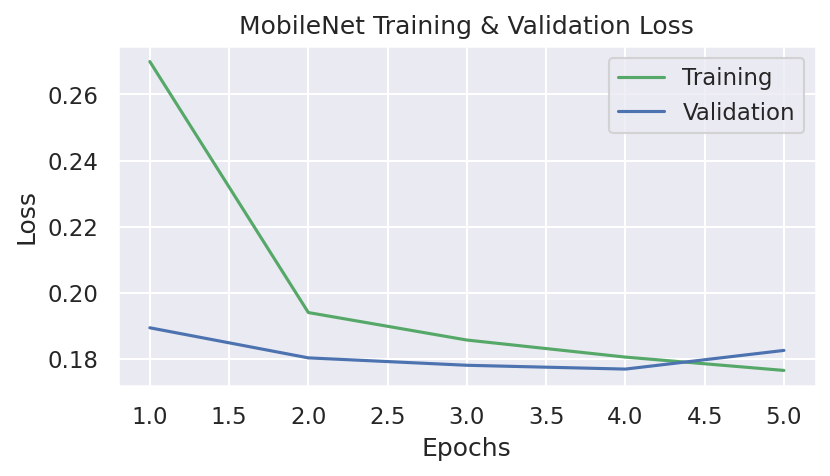

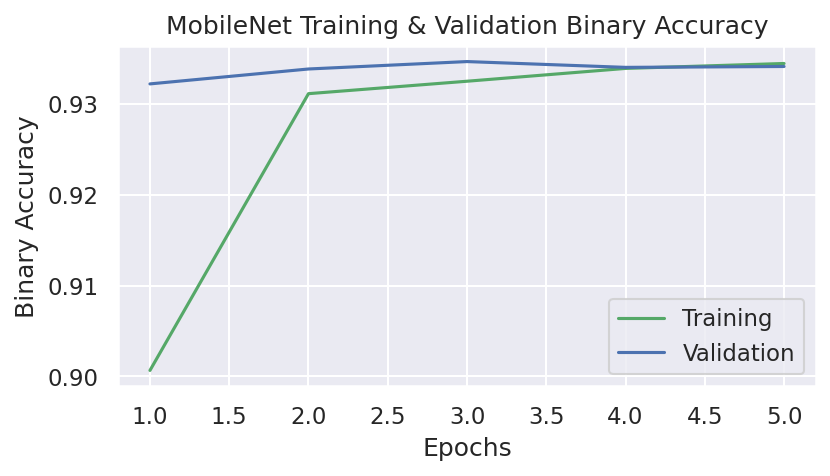

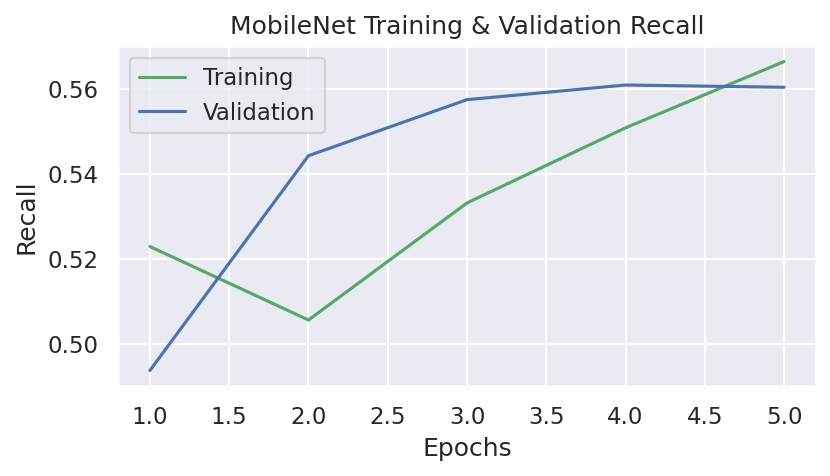

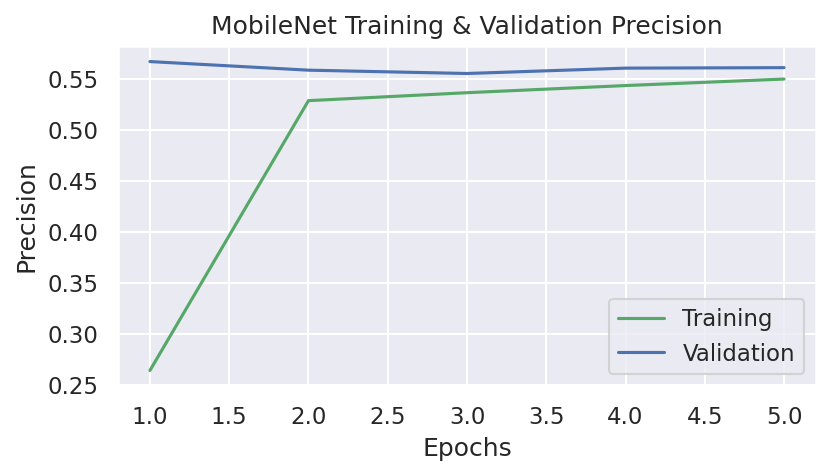

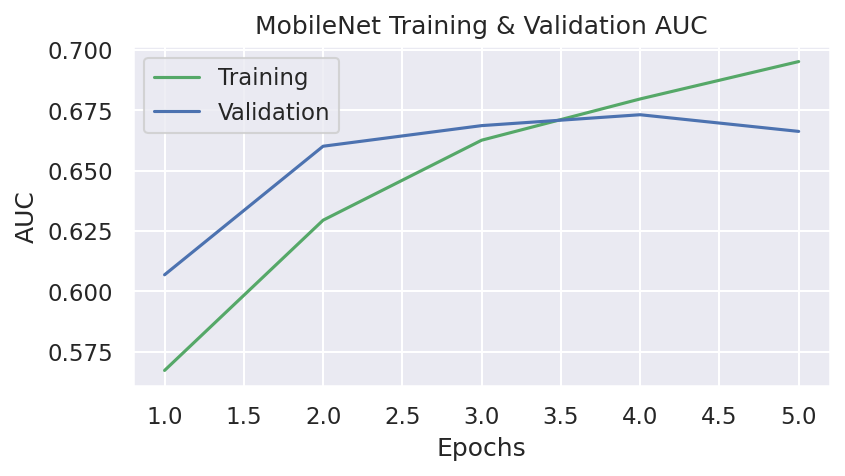

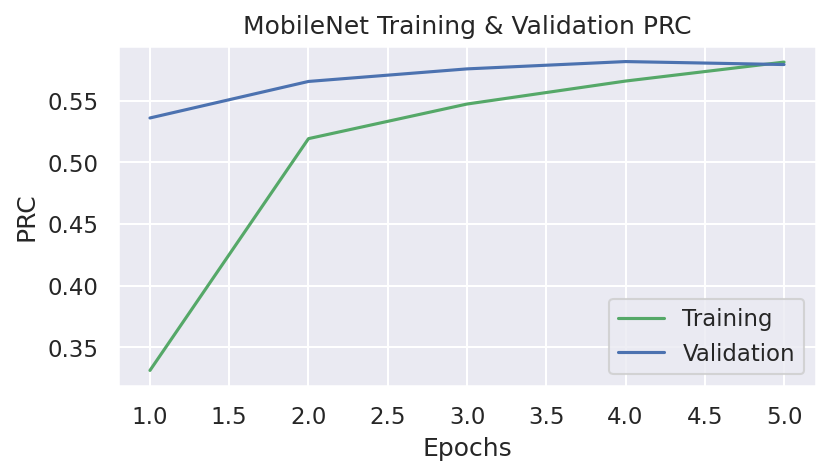

In [15]:
plt.figure(1, figsize = (6,3))
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['loss'], 'g', label = 'Training')
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['val_loss'], 'b', label = 'Validation')
plt.title(f'{MODEL_NAME} Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(2, figsize = (6,3))
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['binary_accuracy'], 'g', label = 'Training')
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['val_binary_accuracy'], 'b', label = 'Validation')
plt.title(f'{MODEL_NAME} Training & Validation Binary Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Binary Accuracy')
plt.legend()
plt.show()

plt.figure(3, figsize = (6,3))
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['recall'], 'g', label = 'Training')
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['val_recall'], 'b', label = 'Validation')
plt.title(f'{MODEL_NAME} Training & Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

plt.figure(4, figsize = (6,3))
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['precision'], 'g', label = 'Training')
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['val_precision'], 'b', label = 'Validation')
plt.title(f'{MODEL_NAME} Training & Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()

plt.figure(6, figsize = (6,3))
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['auc'], 'g', label = 'Training')
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['val_auc'], 'b', label = 'Validation')
plt.title(f'{MODEL_NAME} Training & Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.show()

plt.figure(7, figsize = (6,3))
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['prc'], 'g', label = 'Training')
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['val_prc'], 'b', label = 'Validation')
plt.title(f'{MODEL_NAME} Training & Validation PRC')
plt.xlabel('Epochs')
plt.ylabel('PRC')
plt.legend()
plt.show()

In [16]:
def calculate_cm(y_true, y_pred):
    fp = np.sum((y_pred == 1) & (y_true == 0))
    tp = np.sum((y_pred == 1) & (y_true == 1))
    fn = np.sum((y_pred == 0) & (y_true == 1))
    tn = np.sum((y_pred == 0) & (y_true == 0))
    return tp, fp, fn, tn

def calculate_recall(tp, fp, fn, tn):
    return (tp)/(tp + fn)

def calculate_fallout(tp, fp, fn, tn):
    return (fp)/(fp + tn)

def calculate_fpr_tpr(y_true, y_pred):
    tp, fp, fn, tn = calculate_cm(y_true, y_pred)
    tpr = calculate_recall(tp, fp, fn, tn)
    fpr = calculate_fallout(tp, fp, fn, tn)
    return fpr, tpr

In [17]:
# model.save_weights(f"./saved_weights_MLBCE/{MODEL_NAME}_{EPOCHS}_weights.h5")
evaluation = model.evaluate(test_gen)

1402/1402 [==============================] - 662s 472ms/step - loss: 0.1843 - tp: 11923.0000 - fp: 5849.0000 - tn: 302143.0000 - fn: 16445.0000 - binary_accuracy: 0.9337 - precision: 0.5555 - recall: 0.5565 - auc: 0.6651 - prc: 0.5758


In [18]:
test_loss = evaluation[0]
TP = evaluation[1]
FP = evaluation[2]
TN = evaluation[3]
FN = evaluation[4]
binary_accuracy = evaluation[5] * 100
auc = evaluation[8] * 100
auc_pr = evaluation[9] * 100

specificity = (TN / (TN + FP)) * 100
recall = (TP / (TP + FN)) * 100
precision = (TP / (TP + FP)) * 100
f1_score = (2 * recall * precision) / (recall + precision)

print(f"Testing Loss: \t\t{test_loss}\n")
print(f"True Positives: \t{TP}\nFalse Positives: \t{FP}\nTrue Negatives: \t{TN}\nFalse Negatives: \t{FN}\n")
print(f"Binary Accuracy: \t{binary_accuracy}")
print(f"Average Recall: \t{recall}\nAverage Precision: \t{precision}\nF1-Score: \t\t{f1_score}\nAverage Specificity: \t{specificity}\n")
print(f"AUC: \t\t\t{auc}\nAUC-PR: \t\t{auc_pr}")

Testing Loss: 		0.18430276215076447

True Positives: 	11923.0
False Positives: 	5849.0
True Negatives: 	302143.0
False Negatives: 	16445.0

Binary Accuracy: 	93.3720052242279
Average Recall: 	42.02975183305133
Average Precision: 	67.08867882061669
F1-Score: 		51.681837884698744
Average Specificity: 	98.10092469934284

AUC: 			66.51018857955933
AUC-PR: 		57.57858753204346


In [19]:
test_gen.reset()
predictions = model.predict(test_gen)

In [20]:
def binary_accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred)))

def precision_threshold(threshold = 0.5):
    def precision(y_true, y_pred):
        threshold_value = threshold
        y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold_value), K.floatx())
        true_positives = K.round(K.sum(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(y_pred)
        precision_ratio = true_positives / (predicted_positives + K.epsilon())
        return precision_ratio
    return precision

def recall_threshold(threshold = 0.5):
    def recall(y_true, y_pred):
        threshold_value = threshold
        y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold_value), K.floatx())
        true_positives = K.round(K.sum(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.clip(y_true, 0, 1))
        recall_ratio = true_positives / (possible_positives + K.epsilon())
        return recall_ratio
    return recall

def fbeta_score_threshold(beta = 1, threshold = 0.5):
    def fbeta_score(y_true, y_pred):
        threshold_value = threshold
        beta_value = beta
        p = precision_threshold(threshold_value)(y_true, y_pred)
        r = recall_threshold(threshold_value)(y_true, y_pred)
        bb = beta_value ** 2
        fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
        return fbeta_score
    return fbeta_score
    
def print_results(beta, threshold, test_labels, prediction):
    accuracy = K.eval(binary_accuracy(K.variable(value = test_labels), K.variable(value = prediction)))
    precision = K.eval(precision_threshold(threshold = threshold)(K.variable(value = test_labels), K.variable(value = prediction)))
    recall = K.eval(recall_threshold(threshold = threshold)(K.variable(value = test_labels), K.variable(value = prediction)))
    f1_score = K.eval(fbeta_score_threshold(beta = beta, threshold = threshold)(K.variable(value = test_labels), K.variable(value = prediction)))
    print(f"BETA: {beta}, THRESHOLD: {threshold}")
    print (f"Binary Accuracy: \t{accuracy * 100} % \nRecall: \t\t{recall * 100} % \nPrecision: \t\t{precision * 100} % \nF1-Score: \t\t{f1_score * 100} %\n")

In [21]:
test_labels = []
for label in test_gen.labels:
    test_labels.append(label)

# # Results with F Score giving more weightage to Recall
# for threshold in THRESHOLDS:
#     print_results(beta = BETA_FOR_BIASED_RECALL, threshold = threshold, test_labels = test_labels, prediction = predictions)

# # Results with F Score giving more weightage to Precision
# for threshold in THRESHOLDS:
#     print_results(beta = BETA_FOR_BIASED_PRECISION, threshold = threshold, test_labels = test_labels, prediction = predictions)

# Results with F Score giving equal weightage to Recall and Precision
for threshold in THRESHOLDS:
    print_results(beta = BETA_WITH_NO_BIAS, threshold = threshold, test_labels = test_labels, prediction = predictions)

BETA: 1, THRESHOLD: 0.1
Binary Accuracy: 	93.37198138237 % 
Recall: 		75.24675726890564 % 
Precision: 		37.58760392665863 % 
F1-Score: 		50.132691860198975 %

BETA: 1, THRESHOLD: 0.2
Binary Accuracy: 	93.37198138237 % 
Recall: 		64.14974331855774 % 
Precision: 		47.696179151535034 % 
F1-Score: 		54.712724685668945 %

BETA: 1, THRESHOLD: 0.3
Binary Accuracy: 	93.37198138237 % 
Recall: 		55.65425753593445 % 
Precision: 		55.55242896080017 % 
F1-Score: 		55.60328960418701 %

BETA: 1, THRESHOLD: 0.4
Binary Accuracy: 	93.37198138237 % 
Recall: 		48.237451910972595 % 
Precision: 		62.0561420917511 % 
F1-Score: 		54.281121492385864 %

BETA: 1, THRESHOLD: 0.5
Binary Accuracy: 	93.37198138237 % 
Recall: 		42.02975034713745 % 
Precision: 		67.08868145942688 % 
F1-Score: 		51.68182849884033 %

BETA: 1, THRESHOLD: 0.6
Binary Accuracy: 	93.37198138237 % 
Recall: 		37.217992544174194 % 
Precision: 		70.85906267166138 % 
F1-Score: 		48.802804946899414 %

BETA: 1, THRESHOLD: 0.7
Binary Accuracy: 	93.3

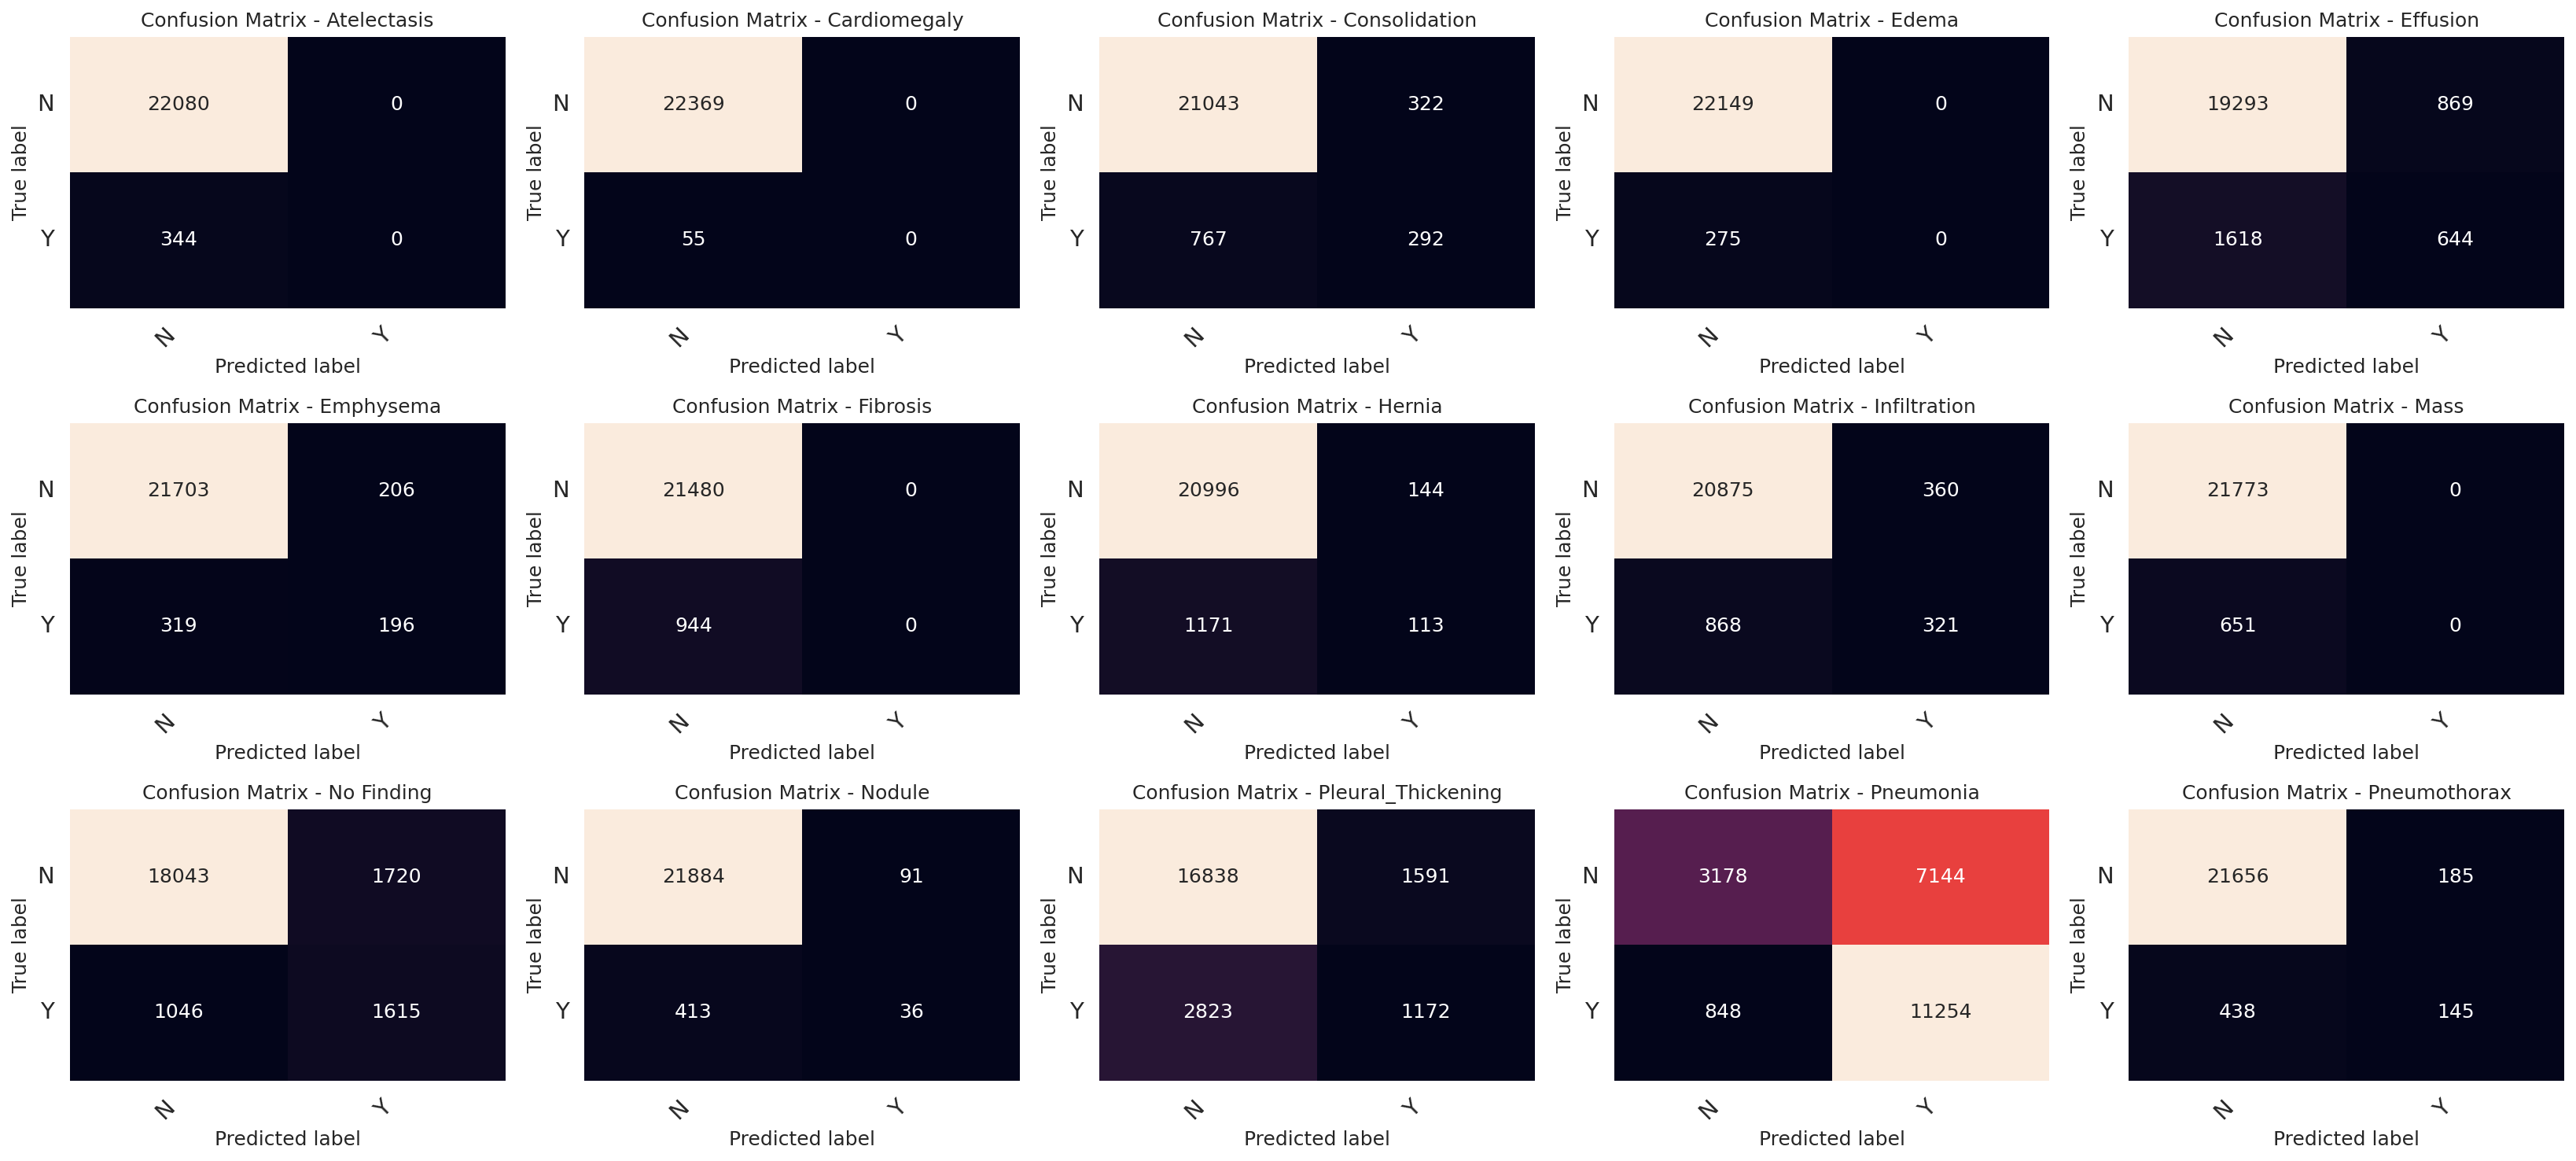

In [22]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize = 14):
    df_cm = pd.DataFrame(confusion_matrix, index = class_names, columns = class_names,)

    try:
        heatmap = sns.heatmap(df_cm, annot = True, fmt = "d", cbar = False, ax = axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation = 0, ha = 'right', fontsize = fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation = 45, ha = 'right', fontsize = fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix - " + class_label)


threshold = 0.3
y_test = test_gen.labels
y_predicted = (predictions >= threshold).astype(int)
confusion_matrix = multilabel_confusion_matrix(y_test, y_predicted)

fig, ax = plt.subplots(3, 5, figsize=(22, 10))
for axes, cfs_matrix, label in zip(ax.flatten(), confusion_matrix, CLASS_LABELS):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    
fig.tight_layout()
plt.show()

[MobileNet with 5 Epochs] - Average AUC: 0.8070407513358545


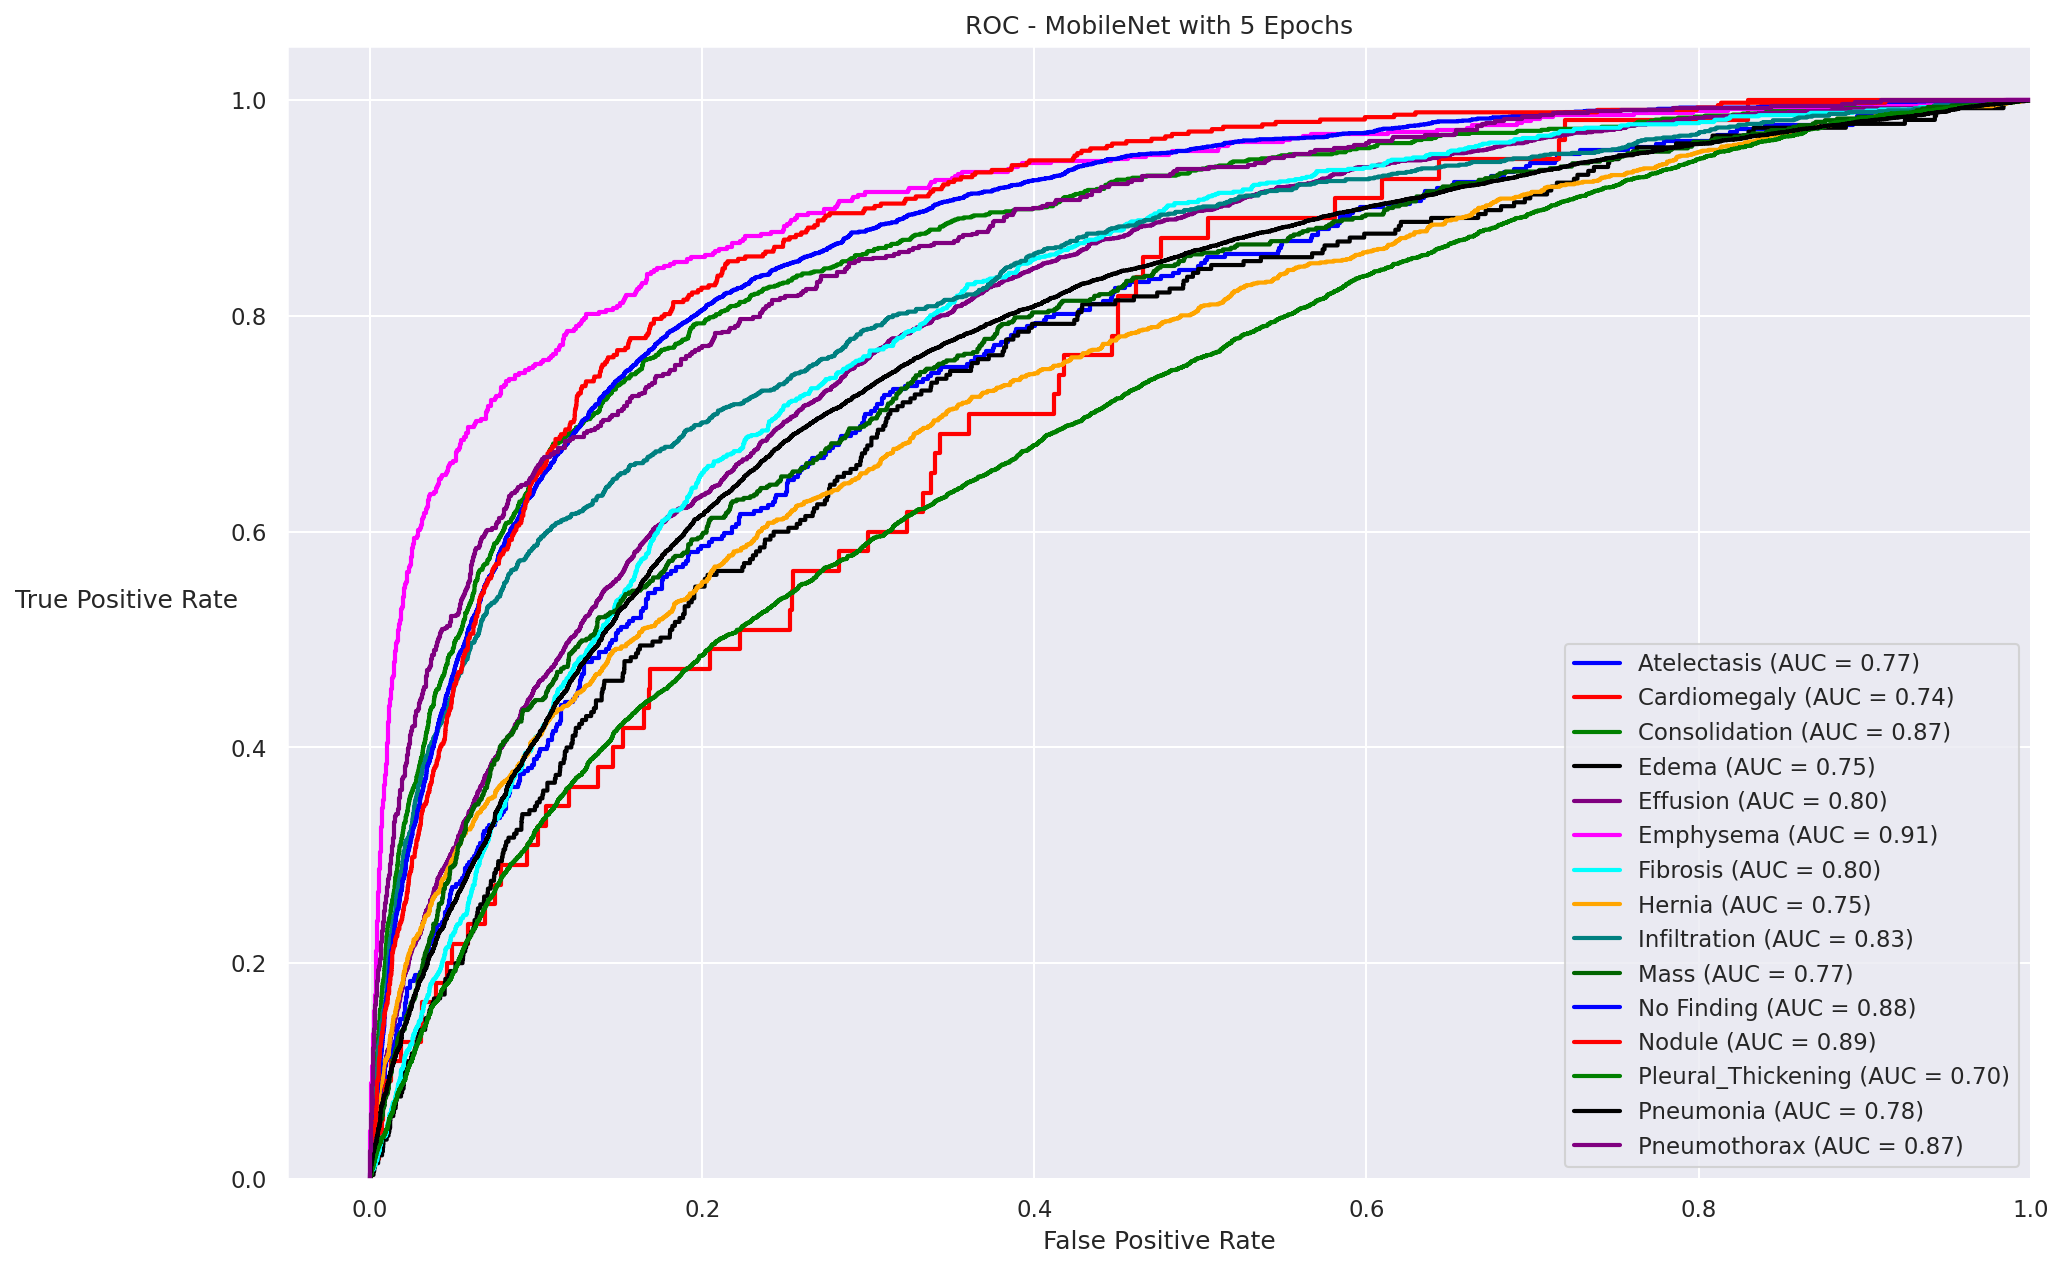

In [23]:
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams['figure.dpi'] = 150

colors = cycle(['blue', 'red', 'green', 'black', 'purple', 'magenta', 'cyan', 'orange', 'teal', 'darkgreen'])
fpr = dict()
tpr = dict()
roc_auc = dict()
lw = 2

for i in range(len(CLASS_LABELS)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], predictions[:, i])
    roc_auc[i] = sklearn.metrics.auc(fpr[i], tpr[i])

avg_auc = 0
for auc_value in roc_auc.values():
    avg_auc += auc_value

print(f"[{MODEL_NAME} with {EPOCHS} Epochs] - Average AUC: {avg_auc / 15}")
    
for i, color in zip(range(len(CLASS_LABELS)), colors):
    plt.plot(fpr[i], tpr[i], color = color, lw = 2, label = '{0} (AUC = {1:0.2f})'''.format(CLASS_LABELS[i], roc_auc[i]))

plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate', rotation = 0, labelpad = 50)
plt.title(f'ROC - {MODEL_NAME} with {EPOCHS} Epochs')
plt.legend(loc = "lower right")
plt.show()

In [24]:
# import os
# import gc
# import cv2
# import time
# import itertools
# import sklearn

# import numpy as np
# import pandas as pd
# import tensorflow as tf
# import tensorflow_addons as tfa
# import seaborn as sns

# from sklearn.preprocessing import label_binarize
# from sklearn.metrics import roc_curve, auc, multilabel_confusion_matrix, ConfusionMatrixDisplay
# from sklearn.multiclass import OneVsRestClassifier
# from itertools import cycle

# from keras import backend as K
# from matplotlib import pyplot as plt

# from glob import glob
# from tqdm import tqdm
# from sklearn.preprocessing import MultiLabelBinarizer
# from sklearn.model_selection import train_test_split
# from keras.preprocessing import image
# from tensorflow.keras import layers
# from tensorflow.keras import models
# from keras_preprocessing.image import ImageDataGenerator

# from keras.layers import Input
# from keras.models import Sequential, Model
# from keras.layers.core import Dense
# from keras.models import Model
# from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense
# from keras.models import Sequential, Model
# from keras.layers import BatchNormalization, Activation
# from keras import regularizers, applications, optimizers, initializers
# from sklearn.metrics import classification_report, confusion_matrix

# from tensorflow.keras.applications import VGG16
# from tensorflow.keras.applications import InceptionV3
# from tensorflow.keras.applications import Xception
# from tensorflow.keras.applications import DenseNet121
# from tensorflow.keras.applications import ResNet50V2
# from tensorflow.keras.applications import MobileNet
# from tensorflow.keras.applications import MobileNetV2
# from tensorflow.keras.applications import EfficientNetB0
# from tensorflow.keras.applications import EfficientNetB1
# from tensorflow.keras.applications import EfficientNetB2
# from tensorflow.keras.applications import EfficientNetB3
# from tensorflow.keras.applications import EfficientNetB4
# from tensorflow.keras.applications import EfficientNetB5
# from tensorflow.keras.applications import EfficientNetB6
# from tensorflow.keras.applications import EfficientNetB7

In [25]:
# def calculate_cm(y_true, y_pred):
#     fp = np.sum((y_pred == 1) & (y_true == 0))
#     tp = np.sum((y_pred == 1) & (y_true == 1))
#     fn = np.sum((y_pred == 0) & (y_true == 1))
#     tn = np.sum((y_pred == 0) & (y_true == 0))
#     return tp, fp, fn, tn

# def calculate_recall(tp, fp, fn, tn):
#     return (tp)/(tp + fn)

# def calculate_fallout(tp, fp, fn, tn):
#     return (fp)/(fp + tn)

# def calculate_fpr_tpr(y_true, y_pred):
#     tp, fp, fn, tn = calculate_cm(y_true, y_pred)
#     tpr = calculate_recall(tp, fp, fn, tn)
#     fpr = calculate_fallout(tp, fp, fn, tn)
#     return fpr, tpr

In [26]:
# image_paths = {os.path.basename(x): x for x in glob(os.path.join('..', 'input', 'data', 'images*', 'images', '*.png'))}
# df = pd.read_csv("/kaggle/input/data/Data_Entry_2017.csv")

# df = df.drop(
#     columns = [
#         "Follow-up #", 
#         "Patient ID", 
#         "Patient Age", 
#         "Patient Gender", 
#         "OriginalImage[Width",
#         "Height]",
#         "OriginalImagePixelSpacing[x",
#         "y]",
#         "Unnamed: 11",
#         "View Position"
#     ], 
#     axis = 1
# )

# df["Image Paths"] = " "
# for row_index in tqdm(range(len(df))):
#     img_name = df.iloc[row_index][0]
#     path = image_paths[img_name]
#     df["Image Paths"][row_index] = path

# unique_labels = set(itertools.chain.from_iterable(df["Finding Labels"].apply(lambda x : x.split('|')).values)) 
# one_hot_labels = pd.DataFrame(0.0, index = np.arange(len(df)), columns = unique_labels)

# for index, row in df.iterrows():
#     labels = row["Finding Labels"].split('|')
#     for label in labels:
#         one_hot_labels.iloc[index][label] = 1.0

# df = pd.concat([df, one_hot_labels], axis = 1)
# df = df.drop(columns = ["Finding Labels"], axis = 1)
# # df.head()

In [27]:
# # df_train, df_test = train_test_split(dataset_info.sample(n = 60000), test_size = 0.20, random_state = 142)
# df_train, df_test = train_test_split(df, test_size = 0.20, random_state = 0)
# df_train, df_val = train_test_split(df_train, test_size = 0.10, random_state = 0)

# print(f"Training Samples: {len(df_train)}\nValidation Samples: {len(df_val)}\nTesting Samples: {len(df_test)}")

In [28]:
# CLASS_LABELS = [
#     "Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Effusion", "Emphysema", "Fibrosis", "Hernia", 
#     "Infiltration", "Mass", "No Finding", "Nodule", "Pleural_Thickening", "Pneumonia","Pneumothorax"
# ]
# IMAGE_SIZE = (224, 224,)
# BATCH_SIZE = 32
# EPOCHS = 15

# BETA_FOR_BIASED_RECALL = 1.3
# BETA_FOR_BIASED_PRECISION = 0.7
# BETA_WITH_NO_BIAS = 1

# THRESHOLDS = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# METRICS = [
#   tf.keras.metrics.TruePositives(name = 'tp'),
#   tf.keras.metrics.FalsePositives(name = 'fp'),
#   tf.keras.metrics.TrueNegatives(name = 'tn'),
#   tf.keras.metrics.FalseNegatives(name = 'fn'), 
#   tf.keras.metrics.BinaryAccuracy(name = 'binary_accuracy'),
#   tf.keras.metrics.Precision(name = 'precision', thresholds = 0.3),
#   tf.keras.metrics.Recall(name = 'recall', thresholds = 0.3),
#   tf.keras.metrics.AUC(name = 'auc', multi_label = True, num_labels = 15, thresholds = THRESHOLDS),
#   tf.keras.metrics.AUC(name = 'prc', curve = 'PR'),
#   tfa.metrics.F1Score(num_classes = len(CLASS_LABELS), threshold = 0.3),
# ]

In [29]:
# def flow_from_dataframe(image_generator, dataframe):
#     df_gen = image_generator.flow_from_dataframe(
#         dataframe,
#         x_col = "Image Paths", 
#         y_col = dataframe.columns[2:],
#         target_size = IMAGE_SIZE,
#         color_mode = 'rgb',
#         class_mode = 'raw',
#         shuffle = False,
#         batch_size = BATCH_SIZE
#     )
#     return df_gen

# def sharpen_image(image):
#     sharp_kernel = np.array(
#         [
#             [0, -1, 0], 
#             [-1, 5, -1], 
#             [0, -1, 0]
#         ])
#     output = cv2.filter2D(src = image, ddepth = -1, kernel = sharp_kernel)
#     return output

In [30]:
# train_data_generator = ImageDataGenerator(
#     rescale = 1. / 255,
#     preprocessing_function = sharpen_image,
#     zca_whitening = False,
#     rotation_range = 20,  # randomly rotate images in the range (degrees, 0 to 180)
#     zoom_range = 0.1, # Randomly zoom image 
#     width_shift_range = 0.1,  # randomly shift images horizontally (fraction of total width)
#     height_shift_range = 0.1,  # randomly shift images vertically (fraction of total height)
#     horizontal_flip = True
# )
# val_data_generator = ImageDataGenerator(
#     rescale = 1. / 255,
#     preprocessing_function = sharpen_image
# )
# test_data_generator = ImageDataGenerator(
#     rescale = 1. / 255,
#     preprocessing_function = sharpen_image
# )

In [31]:
# train_gen = flow_from_dataframe(image_generator = train_data_generator, dataframe = df_train)
# valid_gen = flow_from_dataframe(image_generator = val_data_generator, dataframe = df_val)
# test_gen = flow_from_dataframe(image_generator = test_data_generator, dataframe = df_test)

In [32]:
# SGD_optimizer = tf.keras.optimizers.SGD(
#     learning_rate = 0.0001, 
#     decay = 1e-6, 
#     momentum = 0.9, 
#     nesterov = True
# )
# adam_optimizer = tf.keras.optimizers.Adam(
#     learning_rate = 0.0001,
#     beta_1 = 0.9,
#     beta_2 = 0.999,
# )

In [33]:
# early_stopping_callback = tf.keras.callbacks.EarlyStopping(
#     monitor = 'val_loss',
#     min_delta = 0,
#     patience = 4,
#     verbose = 1,
#     mode = 'auto',
#     baseline = None,
#     restore_best_weights = True
# )

In [34]:
# channels = (3,)
# input_shape = IMAGE_SIZE + channels
# img_input = Input(shape = input_shape)

# MODEL_NAME = "EfficientNetB2"
# base_model = EfficientNetB2(
#     input_shape = input_shape,
#     include_top = False,
#     weights = "imagenet"
# )

# custom_classifier = Sequential()
# custom_classifier.add(GlobalAveragePooling2D(input_shape = base_model.output_shape[1:]))
# custom_classifier.add(Dropout(0.2))

# custom_classifier.add(Dense(256))
# custom_classifier.add(BatchNormalization())
# custom_classifier.add(Activation('relu'))
# custom_classifier.add(Dropout(0.2))

# custom_classifier.add(Dense(50))
# custom_classifier.add(BatchNormalization())
# custom_classifier.add(Activation('relu'))
# custom_classifier.add(Dropout(0.2))

# custom_classifier.add(Dense(15, activation = "sigmoid"))

# model = Model(inputs = base_model.input, outputs = custom_classifier(base_model.output))
# # model.load_weights("/kaggle/working/inceptionv3_5_weights.h5")

# model.compile(
#     optimizer = adam_optimizer,
#     loss = "binary_crossentropy",
#     metrics = METRICS
# )

In [35]:
# start_time = time.time()

# history = model.fit_generator(
#     epochs = EPOCHS,
#     generator = train_gen,
#     steps_per_epoch = train_gen.n / train_gen.batch_size,
#     validation_data = valid_gen,
#     validation_steps = valid_gen.n / valid_gen.batch_size,
#     shuffle = False,
#     verbose = 1,
#     callbacks = None
# )

# print(f"\nTime Taken: {(time.time() - start_time) / 3600 : .4f} Hours")

In [36]:
# plt.figure(1, figsize = (6,3))
# plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['loss'], 'g', label = 'Training')
# plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['val_loss'], 'b', label = 'Validation')
# plt.title(f'{MODEL_NAME} Training & Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# plt.figure(2, figsize = (6,3))
# plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['binary_accuracy'], 'g', label = 'Training')
# plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['val_binary_accuracy'], 'b', label = 'Validation')
# plt.title(f'{MODEL_NAME} Training & Validation Binary Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Binary Accuracy')
# plt.legend()
# plt.show()

# plt.figure(3, figsize = (6,3))
# plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['recall'], 'g', label = 'Training')
# plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['val_recall'], 'b', label = 'Validation')
# plt.title(f'{MODEL_NAME} Training & Validation Recall')
# plt.xlabel('Epochs')
# plt.ylabel('Recall')
# plt.legend()
# plt.show()

# plt.figure(4, figsize = (6,3))
# plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['precision'], 'g', label = 'Training')
# plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['val_precision'], 'b', label = 'Validation')
# plt.title(f'{MODEL_NAME} Training & Validation Precision')
# plt.xlabel('Epochs')
# plt.ylabel('Precision')
# plt.legend()
# plt.show()

# plt.figure(6, figsize = (6,3))
# plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['auc'], 'g', label = 'Training')
# plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['val_auc'], 'b', label = 'Validation')
# plt.title(f'{MODEL_NAME} Training & Validation AUC')
# plt.xlabel('Epochs')
# plt.ylabel('AUC')
# plt.legend()
# plt.show()

# plt.figure(7, figsize = (6,3))
# plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['prc'], 'g', label = 'Training')
# plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['val_prc'], 'b', label = 'Validation')
# plt.title(f'{MODEL_NAME} Training & Validation PRC')
# plt.xlabel('Epochs')
# plt.ylabel('PRC')
# plt.legend()
# plt.show()

In [37]:
# # model.save_weights(f"/kaggle/working/VGG16_{EPOCHS}_weights.h5")
# evaluation = model.evaluate(test_gen)

In [38]:
# test_loss = evaluation[0]
# TP = evaluation[1]
# FP = evaluation[2]
# TN = evaluation[3]
# FN = evaluation[4]
# binary_accuracy = evaluation[5] * 100
# auc = evaluation[8] * 100
# auc_pr = evaluation[9] * 100

# specificity = (TN / (TN + FP)) * 100
# recall = (TP / (TP + FN)) * 100
# precision = (TP / (TP + FP)) * 100
# f1_score = (2 * recall * precision) / (recall + precision)

# print(f"Testing Loss: \t\t{test_loss}\n")
# print(f"True Positives: \t{TP}\nFalse Positives: \t{FP}\nTrue Negatives: \t{TN}\nFalse Negatives: \t{FN}\n")
# print(f"Binary Accuracy: \t{binary_accuracy}")
# print(f"Average Recall: \t{recall}\nAverage Precision: \t{precision}\nF1-Score: \t\t{f1_score}\nAverage Specificity: \t{specificity}\n")
# print(f"AUC: \t\t\t{auc}\nAUC-PR: \t\t{auc_pr}")

In [39]:
# test_gen.reset()
# predictions = model.predict(test_gen)

In [40]:
# def binary_accuracy(y_true, y_pred):
#     return K.mean(K.equal(y_true, K.round(y_pred)))

# def precision_threshold(threshold = 0.5):
#     def precision(y_true, y_pred):
#         threshold_value = threshold
#         y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold_value), K.floatx())
#         true_positives = K.round(K.sum(K.clip(y_true * y_pred, 0, 1)))
#         predicted_positives = K.sum(y_pred)
#         precision_ratio = true_positives / (predicted_positives + K.epsilon())
#         return precision_ratio
#     return precision

# def recall_threshold(threshold = 0.5):
#     def recall(y_true, y_pred):
#         threshold_value = threshold
#         y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold_value), K.floatx())
#         true_positives = K.round(K.sum(K.clip(y_true * y_pred, 0, 1)))
#         possible_positives = K.sum(K.clip(y_true, 0, 1))
#         recall_ratio = true_positives / (possible_positives + K.epsilon())
#         return recall_ratio
#     return recall

# def fbeta_score_threshold(beta = 1, threshold = 0.5):
#     def fbeta_score(y_true, y_pred):
#         threshold_value = threshold
#         beta_value = beta
#         p = precision_threshold(threshold_value)(y_true, y_pred)
#         r = recall_threshold(threshold_value)(y_true, y_pred)
#         bb = beta_value ** 2
#         fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
#         return fbeta_score
#     return fbeta_score
    
# def print_results(beta, threshold, test_labels, prediction):
#     accuracy = K.eval(binary_accuracy(K.variable(value = test_labels), K.variable(value = prediction)))
#     precision = K.eval(precision_threshold(threshold = threshold)(K.variable(value = test_labels), K.variable(value = prediction)))
#     recall = K.eval(recall_threshold(threshold = threshold)(K.variable(value = test_labels), K.variable(value = prediction)))
#     f1_score = K.eval(fbeta_score_threshold(beta = beta, threshold = threshold)(K.variable(value = test_labels), K.variable(value = prediction)))
#     print(f"BETA: {beta}, THRESHOLD: {threshold}")
#     print (f"Binary Accuracy: \t{accuracy * 100} % \nRecall: \t\t{recall * 100} % \nPrecision: \t\t{precision * 100} % \nF1-Score: \t\t{f1_score * 100} %\n")

In [41]:
# test_labels = []
# for label in test_gen.labels:
#     test_labels.append(label)

# # # Results with F Score giving more weightage to Recall
# # for threshold in THRESHOLDS:
# #     print_results(beta = BETA_FOR_BIASED_RECALL, threshold = threshold, test_labels = test_labels, prediction = predictions)

# # # Results with F Score giving more weightage to Precision
# # for threshold in THRESHOLDS:
# #     print_results(beta = BETA_FOR_BIASED_PRECISION, threshold = threshold, test_labels = test_labels, prediction = predictions)

# # Results with F Score giving equal weightage to Recall and Precision
# for threshold in THRESHOLDS:
#     print_results(beta = BETA_WITH_NO_BIAS, threshold = threshold, test_labels = test_labels, prediction = predictions)

In [42]:
# def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):
#     df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names,)

#     try:
#         heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
#     except ValueError:
#         raise ValueError("Confusion matrix values must be integers.")
    
#     heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
#     heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
#     axes.set_ylabel('True label')
#     axes.set_xlabel('Predicted label')
#     axes.set_title("Confusion Matrix - " + class_label)

In [43]:
# threshold = 0.3
# y_test = test_gen.labels
# y_predicted = (predictions >= threshold).astype(int)
# confusion_matrix = multilabel_confusion_matrix(y_test, y_predicted)

# fig, ax = plt.subplots(3, 5, figsize=(22, 10))
# for axes, cfs_matrix, label in zip(ax.flatten(), confusion_matrix, CLASS_LABELS):
#     print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    
# fig.tight_layout()
# plt.show()

In [44]:
# plt.rcParams["figure.figsize"] = (15,10)
# plt.rcParams['figure.dpi'] = 150

# colors = cycle(['blue', 'red', 'green', 'black', 'purple', 'magenta', 'cyan', 'orange', 'teal', 'darkgreen'])
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# lw = 2

# for i in range(len(CLASS_LABELS)):
#     fpr[i], tpr[i], _ = roc_curve(y_test[:, i], predictions[:, i])
#     roc_auc[i] = sklearn.metrics.auc(fpr[i], tpr[i])
    
# for i, color in zip(range(len(CLASS_LABELS)), colors):
#     plt.plot(fpr[i], tpr[i], color = color, lw = 2, label = '{0} (AUC = {1:0.2f})'''.format(CLASS_LABELS[i], roc_auc[i]))

# plt.xlim([-0.05, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title(f'ROC - {MODEL_NAME} with {EPOCHS} Epochs')
# plt.legend(loc = "lower right")
# plt.show()

In [45]:
# avg_auc = 0
# for auc_value in roc_auc:
#     avg_auc += auc_value

# print("[{MODEL_NAME} with {EPOCHS} Epochs] - Average AUC: {avg_auc / 15}")